In [ ]:
import random 
import json
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    red, green, blue = tableau20[i]
    tableau20[i] = (red / 255., green / 255., blue / 255.)

markers=['o','v','^','<','>','8','s','d','h','H','+','x','X','D','d','|','_']

In [ ]:
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt-get install texlive-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils gho

In [ ]:
plt.rcParams['text.latex.preamble'] = [r"\usepackage{lmodern}"]
# plt.rcParams['text.latex.preamble'] = [r"\usepackage{upgreek}"]
rcParams['figure.figsize'] = 8.5, 6
rcParams['text.usetex'] = True
rcParams['figure.dpi'] = 190
rcParams['font.family'] = 'lmodern'
rcParams['font.size'] = '15'
rcParams['text.latex.unicode'] = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


# Plot function

In [ ]:
def plot_curves(curves, filename=None, plot_std=True):
  ax = plt.subplot(111)  
  ax.spines["top"].set_visible(False)  
  ax.spines["bottom"].set_visible(False)  
  ax.spines["right"].set_visible(False)  
  ax.spines["left"].set_visible(False)  

  ax.get_xaxis().tick_bottom()  
  ax.get_yaxis().tick_left()

  def plot_with_bar(l):
    l,l_,_l = av_std(l)

  for i, (curve_lbl, curve) in enumerate(curves.items()):
    passes = curve['n_passes']
    curve_mean = curve['curve_mean']
    curve_std = curve['curve_std']

    plt.plot(passes, curve_mean, label=curve_lbl, color=tableau20[2*i]) #semilogy
    if plot_std:
      low  = [m - s for m, s in zip(curve_mean, curve_std)]
      high = [m + s for m, s in zip(curve_mean, curve_std)]
      plt.fill_between(passes, low, high, alpha=.3, color=tableau20[i*2], linewidth=0)


  plt.xlabel('Number of passes')
  plt.ylabel('Distance to the optimum')
  plt.grid()
  plt.legend(fancybox=True, framealpha=.5)
  if filename is not None:
    plt.savefig(filename, bbox_inches='tight')
  ax = plt.gca()
  ax.yaxis.grid(True, which='minor', linestyle='-.')
  plt.show()

# Setup the problem

In [ ]:
def build_problem(seed=3, n=100, d=100):
  ### Set random seed
  np.random.seed(seed)

  ### Initialize the variables
  x_0 = 1. / np.sqrt(d) * np.random.randn(d)
  y_0 = 1. / np.sqrt(d) * np.random.randn(d)
  norm_M = 0
  M = np.zeros((n, d, d))
  b = np.zeros((n, d))
  a = np.zeros((n, d))

  ### Simple bilinear objective.
  for i in range(d):
      M[i] = np.zeros((d, d))
      M[i][i, i] = 1
      a[i, :] = 1. / np.sqrt(d) * np.random.randn(d)
      b[i, :] = 1. / np.sqrt(d) * np.random.randn(d)

  ### Compute the solution
  M_mean = np.mean(M, 0)
  b_mean = np.mean(b, 0)
  a_mean = np.mean(a, 0)
  y_star = np.linalg.solve(M_mean, -a_mean)
  x_star = np.linalg.solve(M_mean.T, -b_mean)

  return x_0, y_0, M, a, b, x_star, y_star 

# Functions to get the gradient

In [ ]:
def stochastic_update(x, y, M, a, b):
  n = a.shape[0]
  i = np.random.randint(n)
  x_grad = M[i].dot(y) + a[i]
  y_grad = M[i].T.dot(x) + b[i]
  return x_grad, y_grad  # x_grad / n, y_grad / n 


def get_minibatch_update_func(n=1):
  def minibatch_update(x, y, M, a, b): # previously  n=80):
    n_total = a.shape[0]
    x_grads = np.zeros((100))
    y_grads = np.zeros((100))
    for i in random.sample(list(range(n_total)), n): #range(n):
      #i = np.random.randint(n_total)
      x_grads = x_grads + M[i].dot(y) + a[i]
      y_grads = y_grads + M[i].T.dot(x) + b[i]
    return x_grads, y_grads  
  return minibatch_update


def batch_update(x, y, M, a, b):
  n = a.shape[0]
  x_grads = np.zeros((100))
  y_grads = np.zeros((100))
  for i in range(n):
    x_grads = x_grads + M[i].dot(y) + a[i]
    y_grads = y_grads + M[i].T.dot(x) + b[i]
  return x_grads, y_grads  


def proj(x): 
    # n = x.shape[0]
    # return np.minimum(np.ones(n),np.maximum(-np.ones(n),x))
    # return np.minimum(np.ones(n)*50,np.maximum(-np.ones(n)*50,x))
    return x

# Lookahead

In [ ]:
def lookahead(n_pass, x_0, y_0, x_star, y_star, M, a, b, n, gamma=.1, restart=None, 
              extra=True, k=5, la_alpha=.5, batch=False):
    l_SEM = np.zeros((n_pass//3 if extra else n_pass))
    l_avg_SEM = np.zeros((n_pass//3 if extra else n_pass))
    if type(batch) ==  int:
      _update = get_minibatch_update_func(batch)
    else:
      _update = batch_update if batch else stochastic_update

    x_grad = x_0.copy()
    y_grad = y_0.copy()
    x_avg = x_0.copy()
    y_avg = y_0.copy()

    x_prev = x_grad.copy()
    y_prev = y_grad.copy()

    S_t = 1
    for t in range(n_pass//3 if extra else n_pass):
        if np.random.binomial(1, 1. / n):
            if restart is not None:
                if np.random.binomial(1, restart):
                    x_grad = x_avg.copy() / S_t
                    y_grad = y_avg.copy() / S_t
                    S_t = 1
                    x_avg = x_grad.copy()
                    y_avg = y_grad.copy()
        
        if t > 0 and t % k == 0: # one step backward every k steps forward
          x_grad = x_prev + la_alpha * (x_grad - x_prev)
          y_grad = y_prev + la_alpha * (y_grad - y_prev)
          x_prev = x_grad.copy()
          y_prev = y_grad.copy()

        d_x, d_y = _update(x_grad, y_grad, M, a, b)
        if extra:
            x_extra = proj(x_grad - gamma * d_x)
            y_extra = proj(y_grad + gamma * d_y)
            d_x, _ = _update(x_grad, y_extra, M, a, b)
            _, d_y = _update(x_extra, y_grad, M, a, b)
        x_grad = proj(x_grad - gamma * d_x)
        y_grad = proj(y_grad + gamma * d_y)
        # x_grad = x_grad - gamma * d_x
        # y_grad = y_grad + gamma * d_y

        # update metrics and avg-params
        x_avg += x_grad
        y_avg += y_grad
        S_t += 1
        # if np.mod(t * 10, n) == 0:
        l_SEM[t] = np.linalg.norm(x_grad - x_star) + np.linalg.norm(y_grad - y_star)
        l_avg_SEM[t] = np.linalg.norm(x_avg / S_t - x_star) + np.linalg.norm(y_avg / S_t - y_star)
    return l_SEM, l_avg_SEM

In [ ]:
def run_lookahead_experiment(n_pass=20000, np_rand=5, restart=None, 
                             minibatch_size=1, gamma=0.1, la_alpha=0.4,
                             la_k=450, problem_n=100, problem_d=100, extra=False):
  res = {
      'curves': [],
      'curves-avg': []
  }
  for seed in range(np_rand):
    x_0, y_0, M, a, b, x_star, y_star = build_problem(seed=seed, n=problem_n, d=problem_d)
    look_gd, look_gd_avg = lookahead(n_pass, x_0, y_0, x_star, y_star, M, a, b, 
                                     problem_n, gamma=gamma, restart=restart, extra=extra, 
                                     k=la_k, la_alpha=la_alpha, batch=minibatch_size)
    res['curves'].append(look_gd)
    res['curves-avg'].append(look_gd_avg)
  res['n_passes'] = np.array(range(n_pass)) if not extra else np.array(range(n_pass//3))*3
  res['curve_mean'] = np.array(res['curves']).mean(axis=0)
  res['curve_std'] = np.array(res['curves']).std(axis=0)
  res['curve-avg_mean'] = np.array(res['curves-avg']).mean(axis=0)
  res['curve-avg_std'] = np.array(res['curves-avg']).std(axis=0)
  return res

In [ ]:
res = run_lookahead_experiment(n_pass=20000, 
                                np_rand=5, 
                                restart=None, 
                                minibatch_size=1, 
                                gamma=0.05, 
                                la_alpha=0.3,
                                la_k=2450, 
                                problem_n=100, 
                                problem_d=100, 
                                extra=False)

curves_la = {f"LA-GAN$, B=1$": res}

In [ ]:
res = run_lookahead_experiment(n_pass=20000, 
                                np_rand=5, 
                                restart=None, 
                                minibatch_size=4, 
                                gamma=0.03, 
                                la_alpha=0.3,
                                la_k=2350, 
                                problem_n=100, 
                                problem_d=100, 
                                extra=False)

curves_la[f"LA-GAN$, B=4$"] = res

In [ ]:
res = run_lookahead_experiment(n_pass=20000, 
                                np_rand=5, 
                                restart=None, 
                                minibatch_size=16, 
                                gamma=0.01, 
                                la_alpha=0.3,
                                la_k=1500, 
                                problem_n=100, 
                                problem_d=100, 
                                extra=False)

curves_la[f"LA-GAN$, B=16$"] = res

In [ ]:
res = run_lookahead_experiment(n_pass=20000, 
                                np_rand=5, 
                                restart=None, 
                                minibatch_size=64, 
                                gamma=0.005, 
                                la_alpha=0.3,
                                la_k=450, 
                                problem_n=100, 
                                problem_d=100, 
                                extra=False)

curves_la[f"LA-GAN$, B=64$"] = res

In [ ]:
res = run_lookahead_experiment(n_pass=20000, 
                                np_rand=5, 
                                restart=None, 
                                minibatch_size=100, 
                                gamma=0.2, 
                                la_alpha=0.3,
                                la_k=15, 
                                problem_n=100, 
                                problem_d=100, 
                                extra=False)

curves_la[f"LA-GAN--full-batch"] = res

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


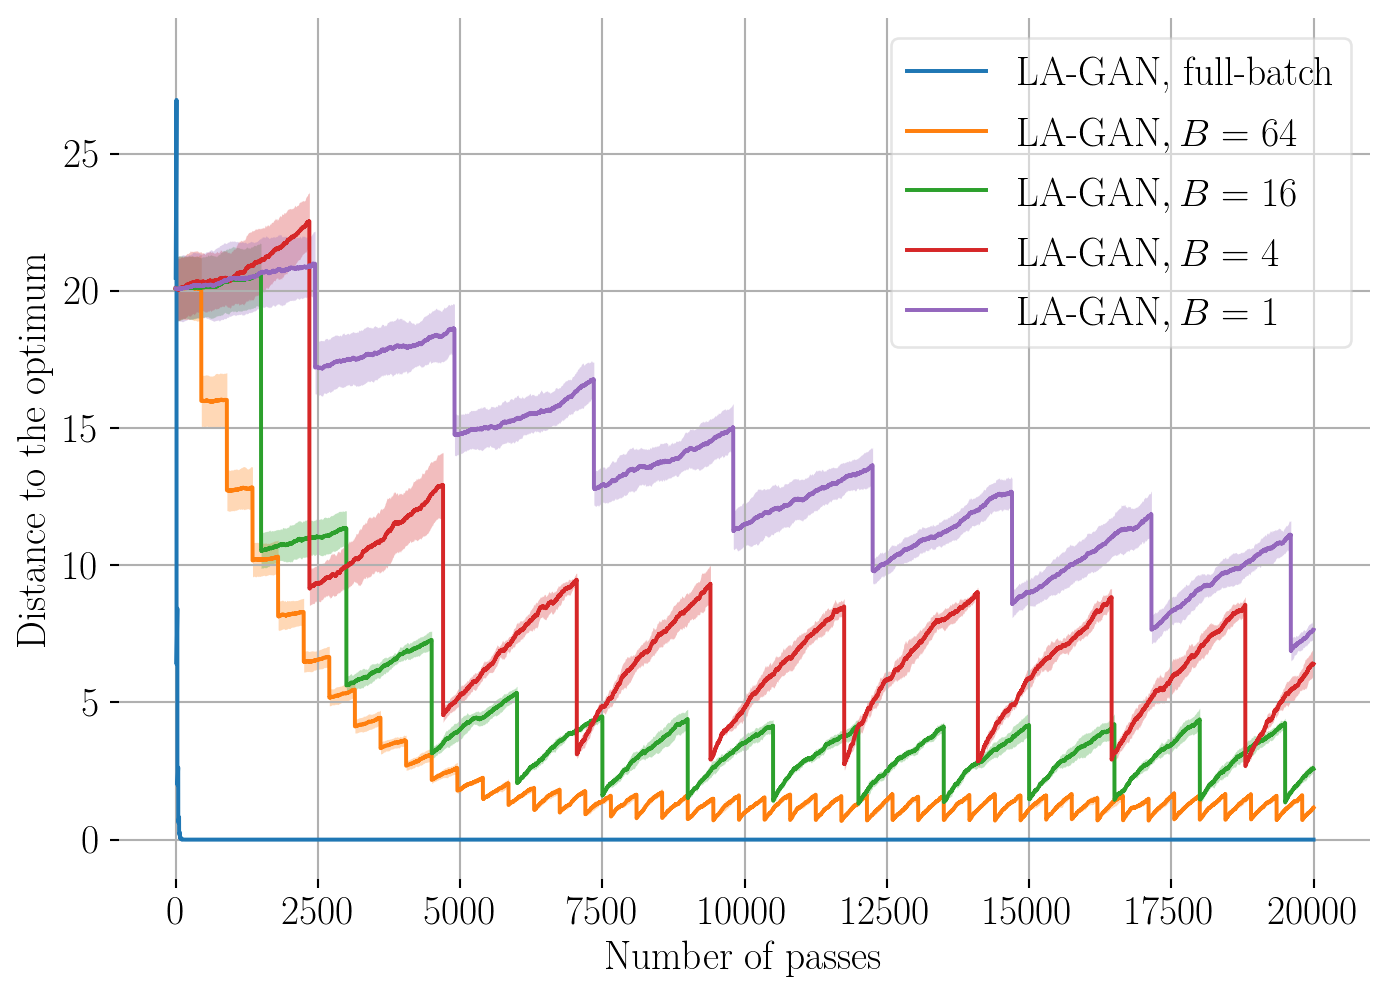

In [ ]:
_curves = {
    f"LA-GAN, full-batch": curves_la[f"LA-GAN--full-batch"],
    f"LA-GAN$, B=64$": curves_la[f"LA-GAN$, B=64$"],
    f"LA-GAN$, B=16$": curves_la[f"LA-GAN$, B=16$"],
    f"LA-GAN$, B=4$": curves_la[f"LA-GAN$, B=4$"],
    f"LA-GAN$, B=1$": curves_la[f"LA-GAN$, B=1$"],
}

plot_curves(_curves, "lookahead_stochastic_bilinear.pdf")

# SGD/SGA

In [ ]:
class AdamOpt:
    def __init__(self , d, beta_1 = .99,beta_2= .999,epsilon_0 = 1e-8):
        self.epsilon_0 = epsilon_0
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.first_moment_x = np.zeros(d)
        self.first_moment_y = np.zeros(d)
        self.second_moment_y = np.zeros(d)
        self.second_moment_x = np.zeros(d)
    def adam_direction(self,x_grad,y_grad,t):
        self.first_moment_x = self.beta_1 * self.first_moment_x + (1- self.beta_1)* x_grad
        self.second_moment_x = self.beta_2 * self.second_moment_x + (1-self.beta_2)  * x_grad**2
        self.first_moment_y = self.beta_1 * self.first_moment_y + (1- self.beta_1)* y_grad
        self.second_moment_y = self.beta_2 * self.second_moment_y + (1-self.beta_2)  * y_grad**2
        d_x_t = self.first_moment_x / (1-self.beta_1**(t+1)) / (np.sqrt(self.second_moment_x)+self.epsilon_0)
        d_y_t = self.first_moment_y / (1-self.beta_1**(t+1)) / (np.sqrt(self.second_moment_y)+self.epsilon_0)
        return (d_x_t,d_y_t)


def sgd_sga(n_pass, x_0, y_0, x_star, y_star, M, a, b, n, d, gamma=.1, restart=None, 
              extra=True, batch=False, adam=False, beta1=0.0):
    l_SEM = np.zeros((n_pass//3 if extra else n_pass))
    l_avg_SEM = np.zeros((n_pass//3 if extra else n_pass))
    if type(batch) ==  int:
      _update = get_minibatch_update_func(batch)
    else:
      _update = batch_update if batch else stochastic_update

    if adam:
      _adam = AdamOpt(d, beta_1=beta1, beta_2=.999, epsilon_0=1e-8)

    x_grad = x_0.copy()
    y_grad = y_0.copy()
    x_avg = x_0.copy()
    y_avg = y_0.copy()

    S_t = 1
    for t in range(n_pass//3 if extra else n_pass):
        if np.random.binomial(1, 1. / n):
            if restart is not None:
                if np.random.binomial(1, restart):
                    x_grad = x_avg.copy() / S_t
                    y_grad = y_avg.copy() / S_t
                    S_t = 1
                    x_avg = x_grad.copy()
                    y_avg = y_grad.copy()

        d_x, d_y = _update(x_grad, y_grad, M, a, b)
        if adam:
          d_x, d_y = _adam.adam_direction(d_x,d_y,t)
        if extra:
            x_extra = proj(x_grad - gamma * d_x)
            y_extra = proj(y_grad + gamma * d_y)
            d_x, _ = _update(x_grad, y_extra, M, a, b)
            _, d_y = _update(x_extra, y_grad, M, a, b)
            if adam:
              d_x, d_y = _adam.adam_direction(d_x,d_y,t)
        x_grad = proj(x_grad - gamma * d_x)
        y_grad = proj(y_grad + gamma * d_y)

        # update metrics and avg-params
        x_avg += x_grad
        y_avg += y_grad
        S_t += 1
        # if np.mod(t * 10, n) == 0:
        l_SEM[t] = np.linalg.norm(x_grad - x_star) + np.linalg.norm(y_grad - y_star)
        l_avg_SEM[t] = np.linalg.norm(x_avg / S_t - x_star) + np.linalg.norm(y_avg / S_t - y_star)
    return l_SEM, l_avg_SEM

In [ ]:
def run_experiment(n_pass=20000, np_rand=5, restart=None, 
                   minibatch_size=1, gamma=0.1, beta1=0.0,
                   problem_n=100, problem_d=100, extra=False, adam=False):
  res = {
      'curves': [],
      'curves-avg': []
  }
  for seed in range(np_rand):
    x_0, y_0, M, a, b, x_star, y_star = build_problem(seed=seed, n=problem_n, d=problem_d)
    res_gd, res_gd_avg = sgd_sga(n_pass, x_0, y_0, x_star, y_star, M, a, b, problem_n, problem_d,
                                 gamma=gamma, restart=restart, beta1=beta1,
                                 batch=minibatch_size, extra=extra, adam=adam)

    res['curves'].append(res_gd)
    res['curves-avg'].append(res_gd_avg)
  res['n_passes'] = np.array(range(n_pass)) if not extra else np.array(range(n_pass//3))*3
  res['curve_mean'] = np.array(res['curves']).mean(axis=0)
  res['curve_std'] = np.array(res['curves']).std(axis=0)
  res['curve-avg_mean'] = np.array(res['curves-avg']).mean(axis=0)
  res['curve-avg_std'] = np.array(res['curves-avg']).std(axis=0)
  return res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=1, 
                     restart=None, 
                     minibatch_size=100, 
                     gamma=0.001,
                     problem_n=100, 
                     problem_d=100, 
                     extra=False,
                     adam=False)

curves_sgdsga = {}
curves_sgdsga[f"SGD/SGA, full-batch"] = res

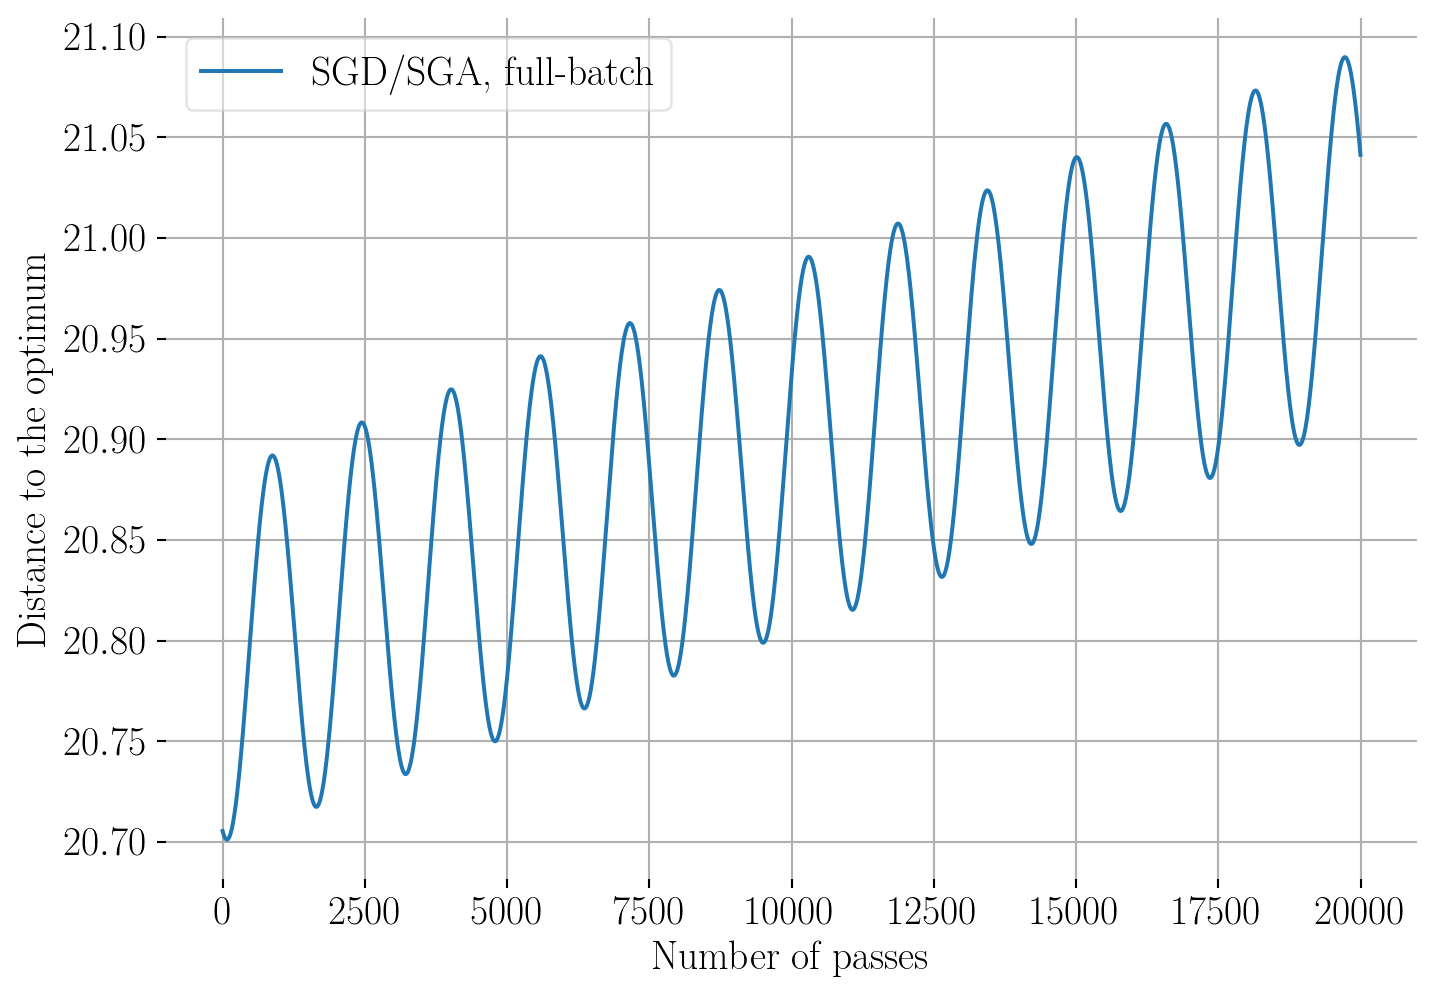

In [ ]:
plot_curves(curves_sgdsga)

# ADAM

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=100, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=-0.9,
                     extra=False,
                     adam=True)

curves_adam = {}
curves_adam[f"Adam--full-batch"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=64, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100,
                     beta1=-0.6, 
                     extra=False,
                     adam=True)

curves_adam[f"Adam$, B=64$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=16, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=-0.3,
                     extra=False,
                     adam=True)

curves_adam[f"Adam$, B=16$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=4, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=-0.1,
                     extra=False,
                     adam=True)

curves_adam[f"Adam$, B=4$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=1, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=0.0,
                     extra=False,
                     adam=True)

curves_adam[f"Adam$, B=1$"] = res

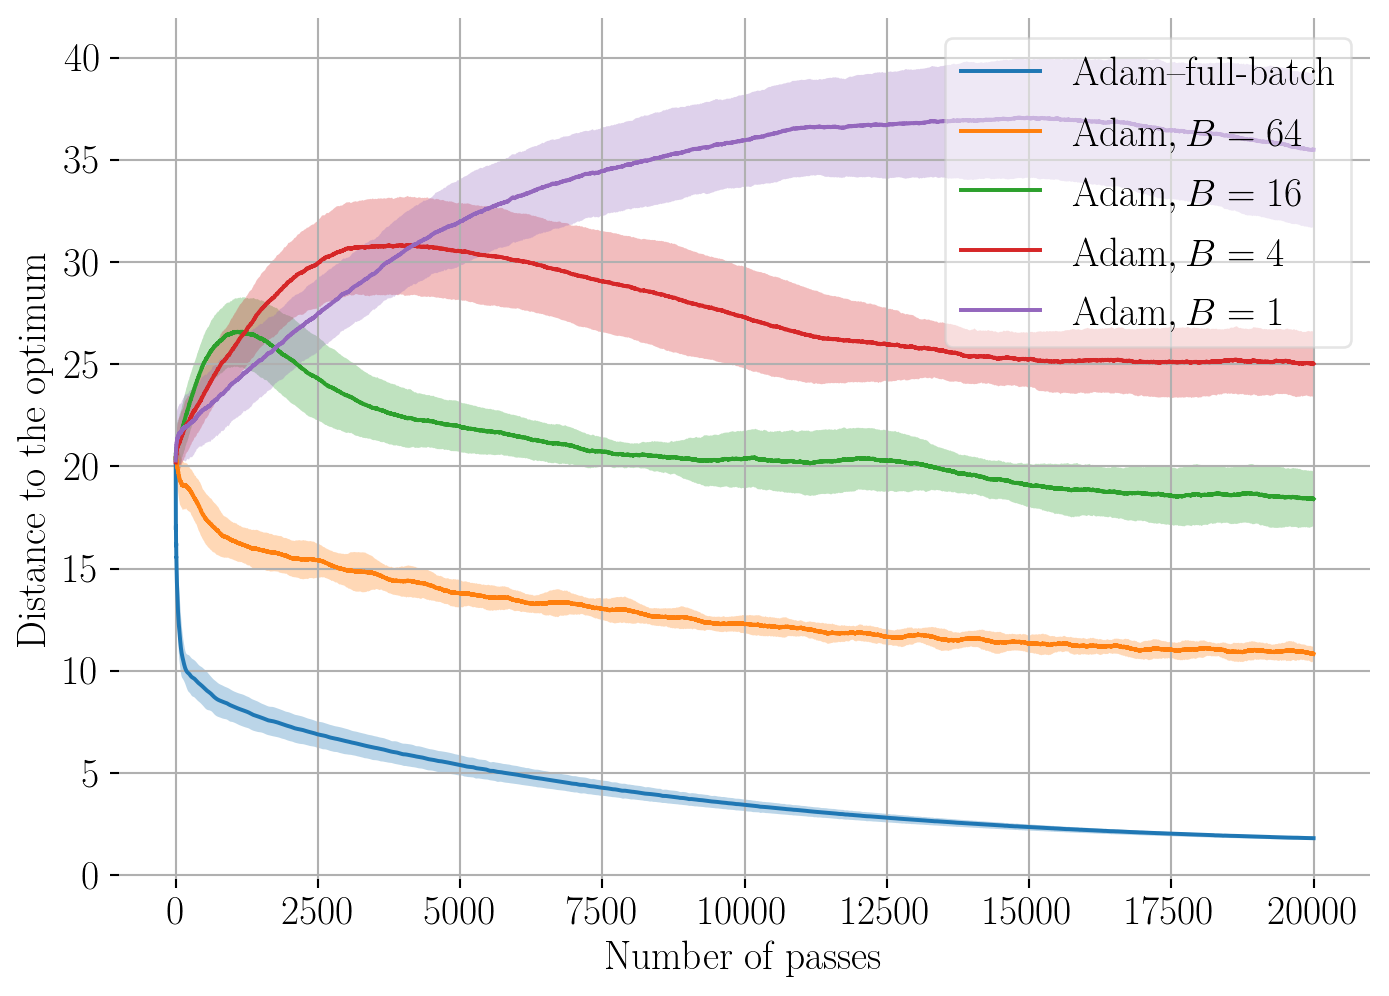

In [ ]:
plot_curves(curves_adam, "adam_stochastic_bilinear.pdf")

# Extragrad + ADAM

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=100, 
                     gamma=0.02,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=-0.6,
                     extra=True,
                     adam=True)

curves_extradam = {}
curves_extradam[f"Extra-Adam, full-batch"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=64, 
                     gamma=0.01,
                     problem_n=100, 
                     problem_d=100,
                     beta1=-0.2, 
                     extra=True,
                     adam=True)

curves_extradam[f"Extra-Adam$, B=64$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=16, 
                     gamma=0.005,#0.01,
                     problem_n=100, 
                     problem_d=100,
                     beta1=-0.0, 
                     extra=True,
                     adam=True)

curves_extradam[f"Extra-Adam$, B=16$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=4, 
                     gamma=0.01,
                     problem_n=100, 
                     problem_d=100,
                     beta1=-0.0, 
                     extra=True,
                     adam=True)

curves_extradam[f"Extra-Adam$, B=4$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=1, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100,
                     beta1=-0.0, 
                     extra=True,
                     adam=True)

curves_extradam[f"Extra-Adam$, B=1$"] = res

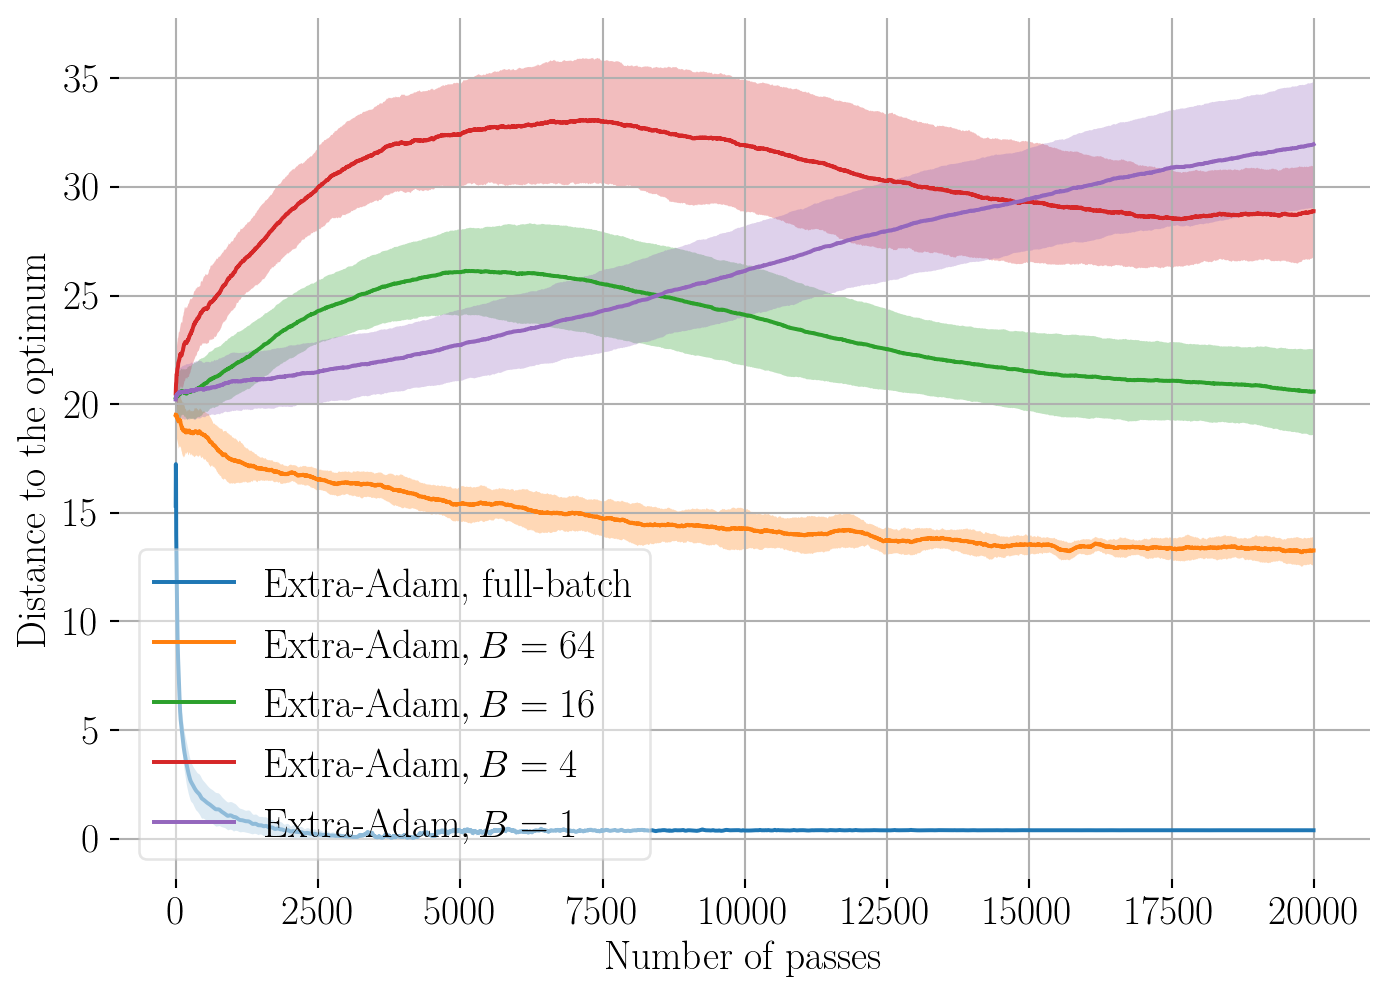

In [ ]:
plot_curves(curves_extradam, "e-adam_stochastic_bilinear.pdf")

# Extragrad

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=100, 
                     gamma=0.8,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=0,
                     extra=True,
                     adam=False)

curves_extra = {}
curves_extra[f"Extragradient, full-batch"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=64, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=0,
                     extra=True,
                     adam=False)

curves_extra[f"Extragradient$, B=64$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=16, 
                     gamma=0.005,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=0,
                     extra=True,
                     adam=False)

curves_extra[f"Extragradient$, B=16$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=4, 
                     gamma=0.04,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=0,
                     extra=True,
                     adam=False)

curves_extra[f"Extragradient$, B=4$"] = res

In [ ]:
res = run_experiment(n_pass=20000, 
                     np_rand=5, 
                     restart=None, 
                     minibatch_size=1, 
                     gamma=0.005,#0.16,
                     problem_n=100, 
                     problem_d=100, 
                     beta1=0,
                     extra=True,
                     adam=False)

curves_extra[f"Extragradient$, B=1$"] = res

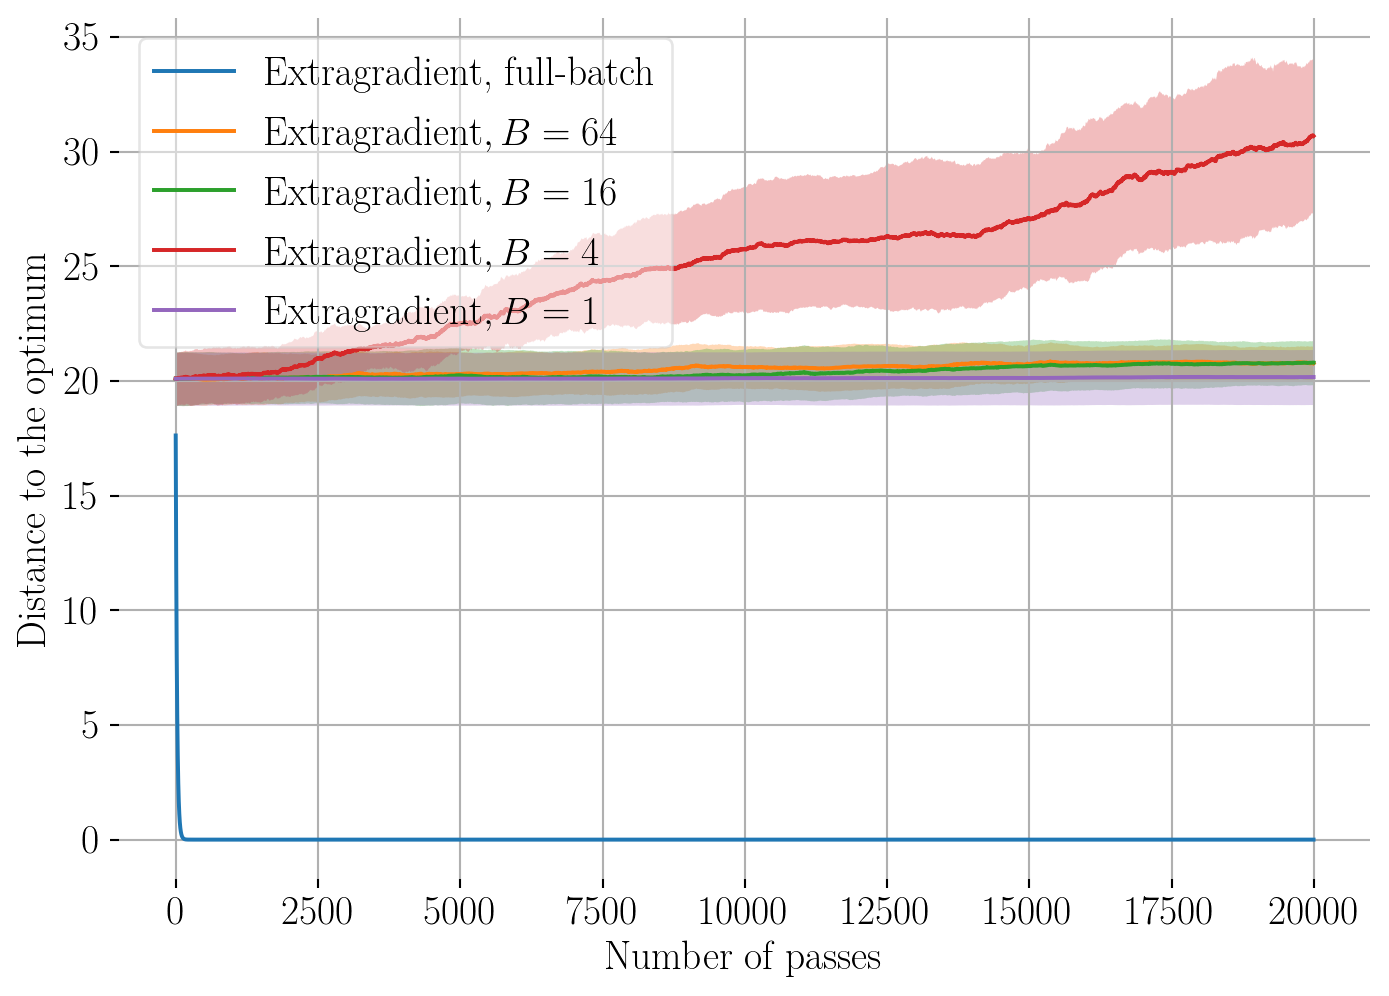

In [ ]:
plot_curves(curves_extra, "extragradient_stochastic_bilinear.pdf")

# Mixing curves together

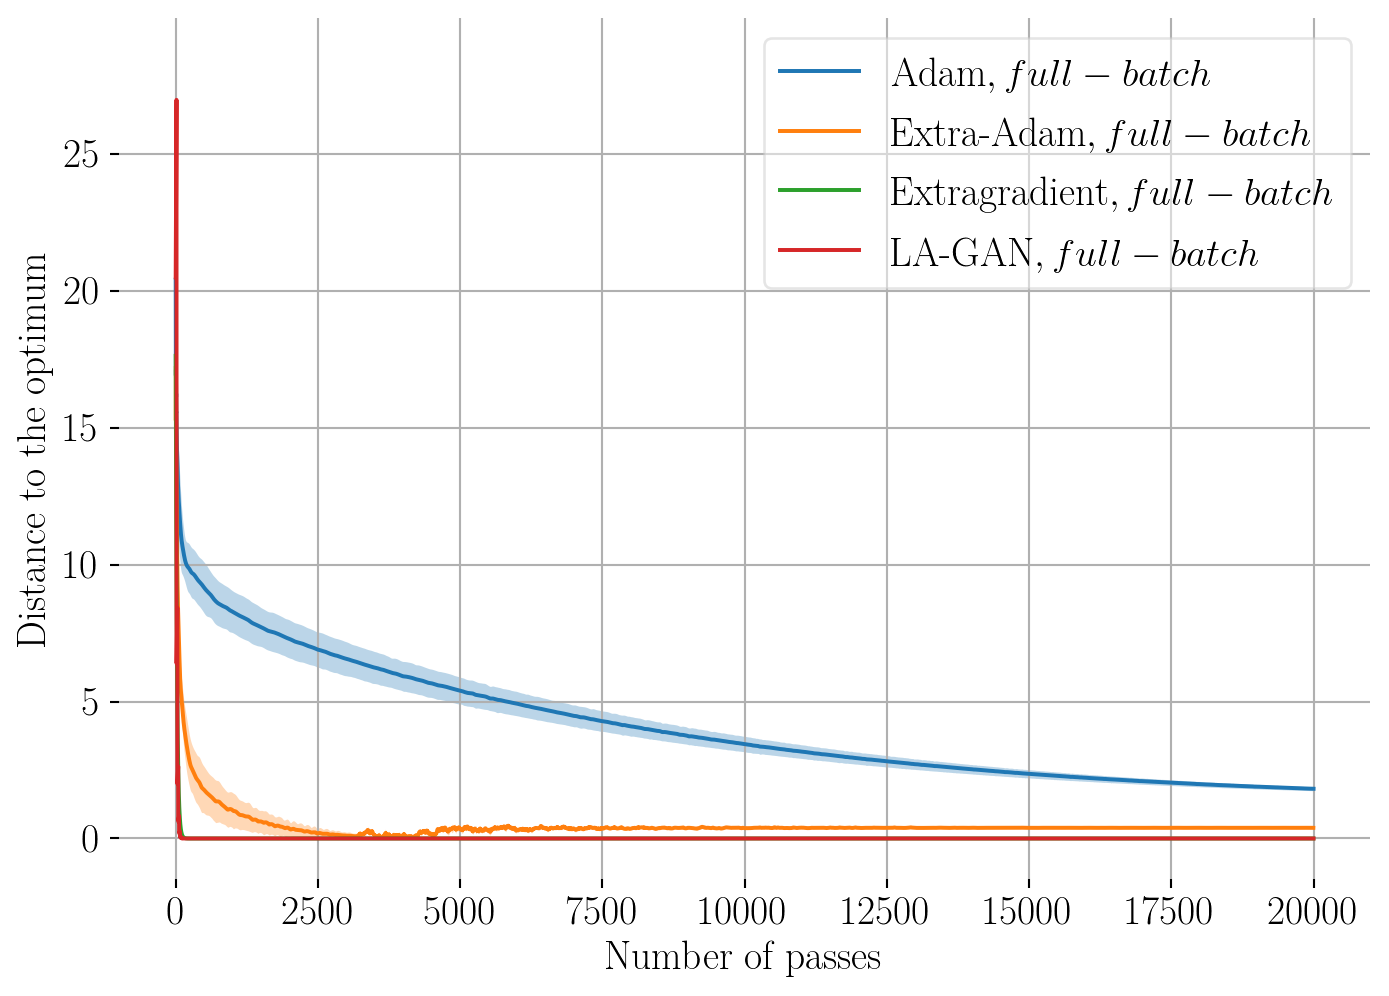

In [ ]:
_curves0 = {
    f"Adam$, full-batch$": curves_adam[f"Adam--full-batch"],
    f"Extra-Adam$, full-batch$": curves_extradam[f"Extra-Adam, full-batch"],
    f"Extragradient$, full-batch$": curves_extra[f"Extragradient, full-batch"],
    f"LA-GAN$, full-batch$": curves_la[f"LA-GAN--full-batch"],
}

plot_curves(_curves0, "stochastic_bilinear_full-batch.pdf")

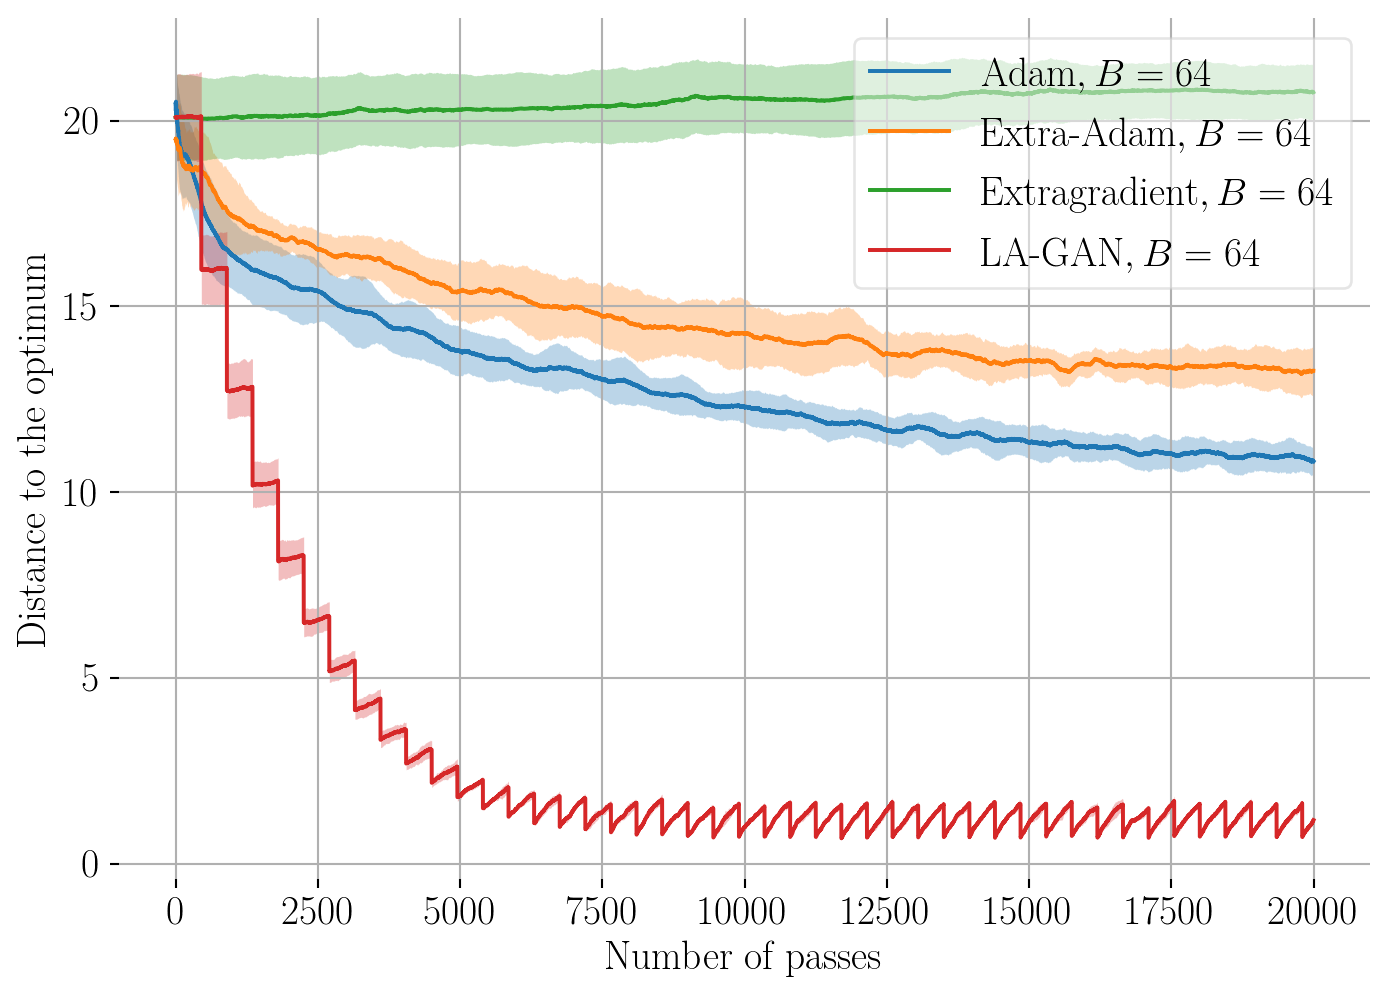

In [ ]:
_curves1 = {
    f"Adam$, B=64$": curves_adam[f"Adam$, B=64$"],
    f"Extra-Adam$, B=64$": curves_extradam[f"Extra-Adam$, B=64$"],
    f"Extragradient$, B=64$": curves_extra[f"Extragradient$, B=64$"],
    f"LA-GAN$, B=64$": curves_la[f"LA-GAN$, B=64$"],
}

plot_curves(_curves1, "stochastic_bilinear_B=64.pdf")

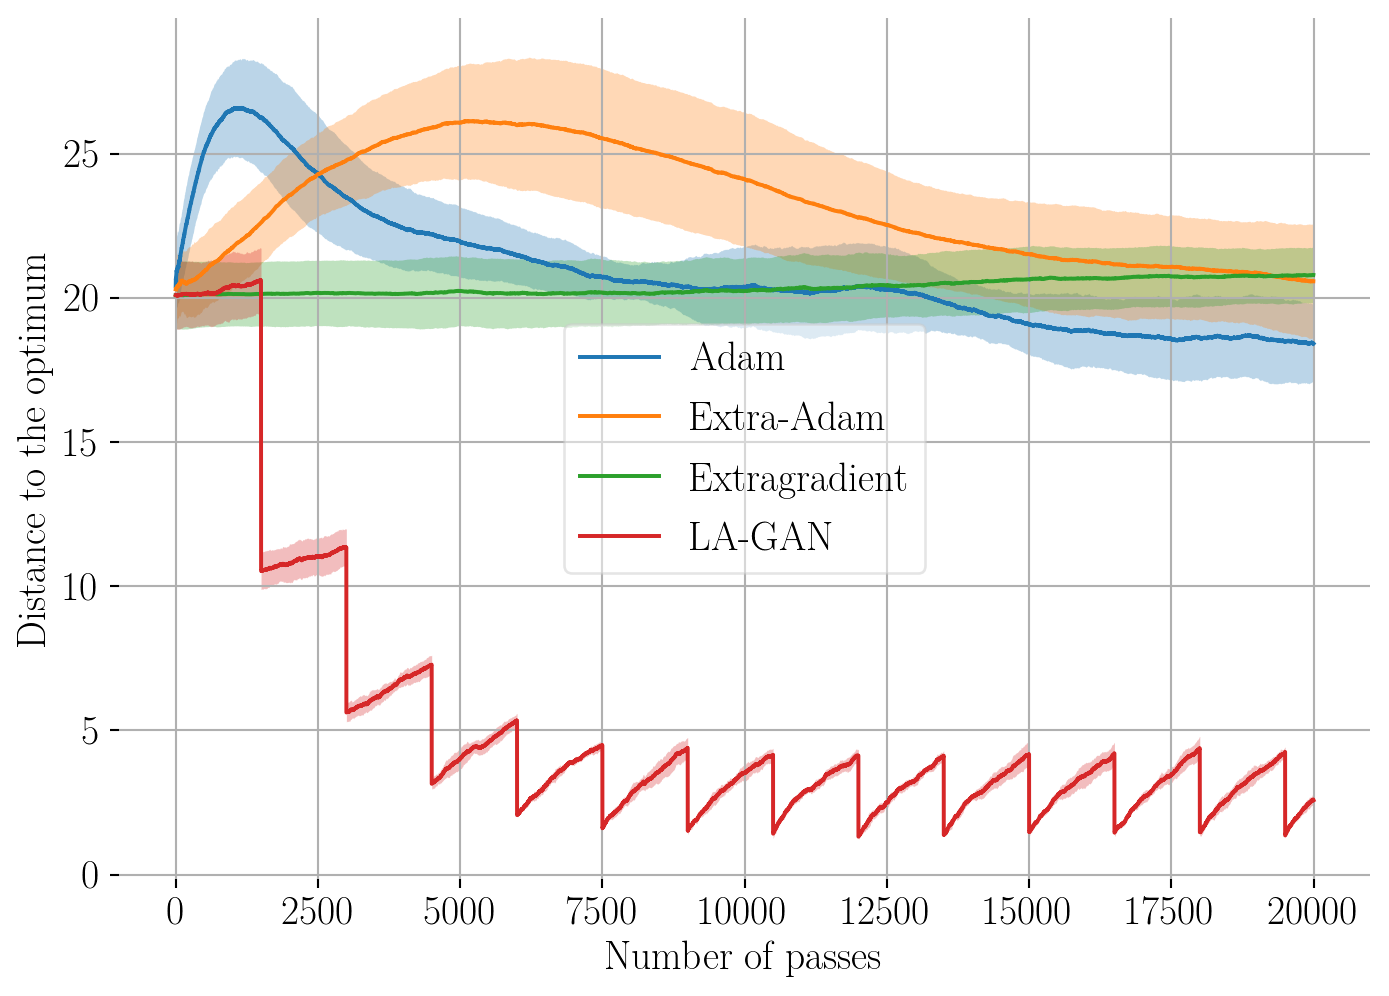

In [ ]:
_curves2 = {
    f"Adam": curves_adam[f"Adam$, B=16$"],
    f"Extra-Adam": curves_extradam[f"Extra-Adam$, B=16$"],
    f"Extragradient": curves_extra[f"Extragradient$, B=16$"],
    f"LA-GAN": curves_la[f"LA-GAN$, B=16$"],
}

plot_curves(_curves2, "stochastic_bilinear_B=16.pdf")

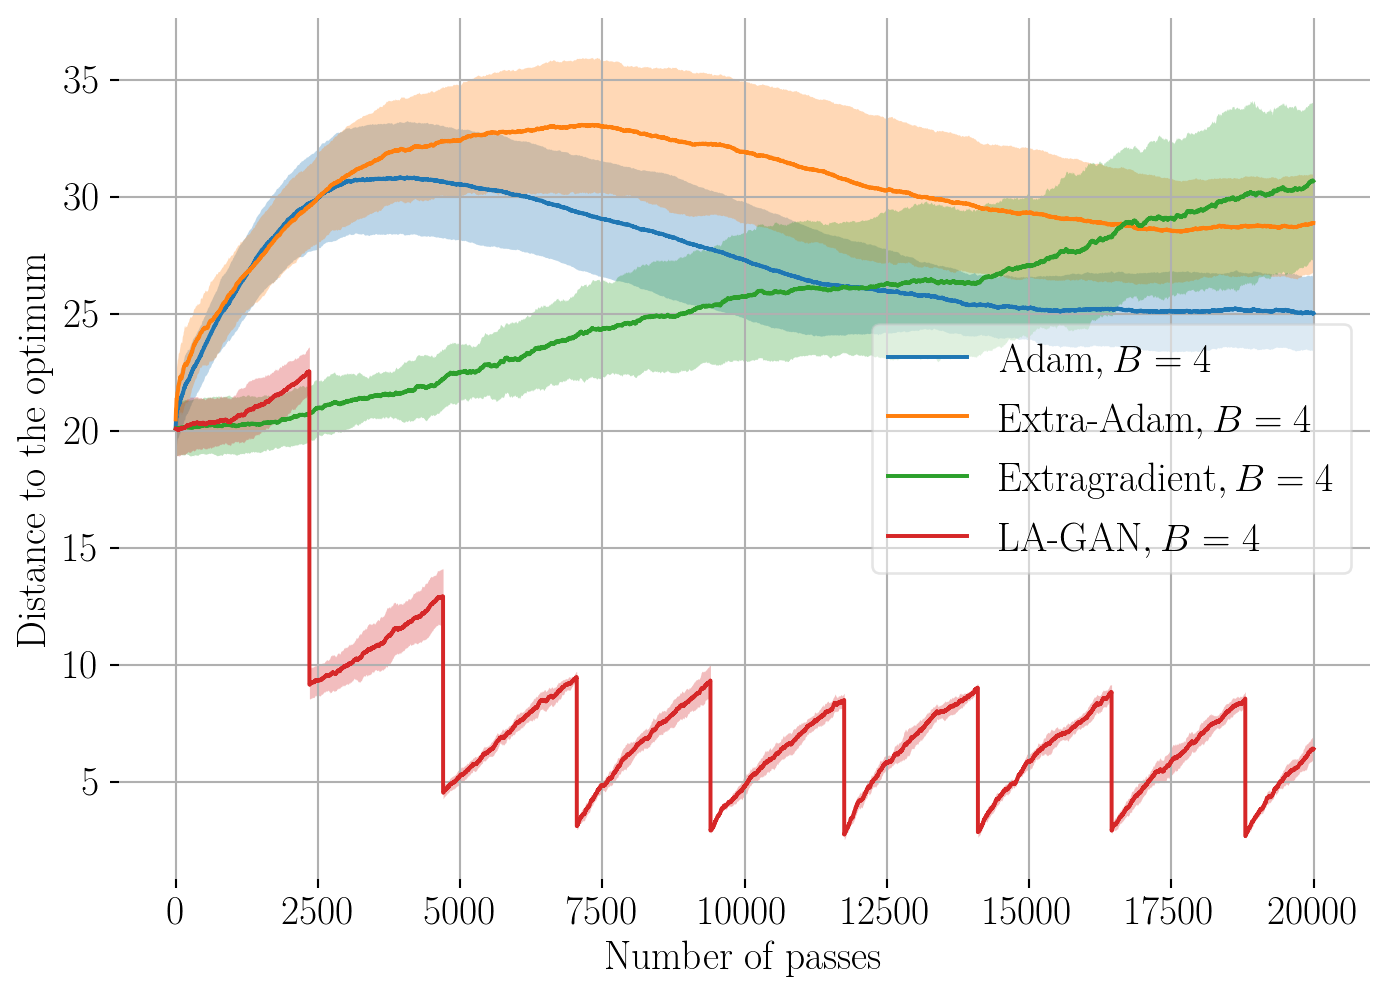

In [ ]:
_curves3 = {
    f"Adam$, B=4$": curves_adam[f"Adam$, B=4$"],
    f"Extra-Adam$, B=4$": curves_extradam[f"Extra-Adam$, B=4$"],
    f"Extragradient$, B=4$": curves_extra[f"Extragradient$, B=4$"],
    f"LA-GAN$, B=4$": curves_la[f"LA-GAN$, B=4$"],
}

plot_curves(_curves3, "stochastic_bilinear_B=4.pdf")

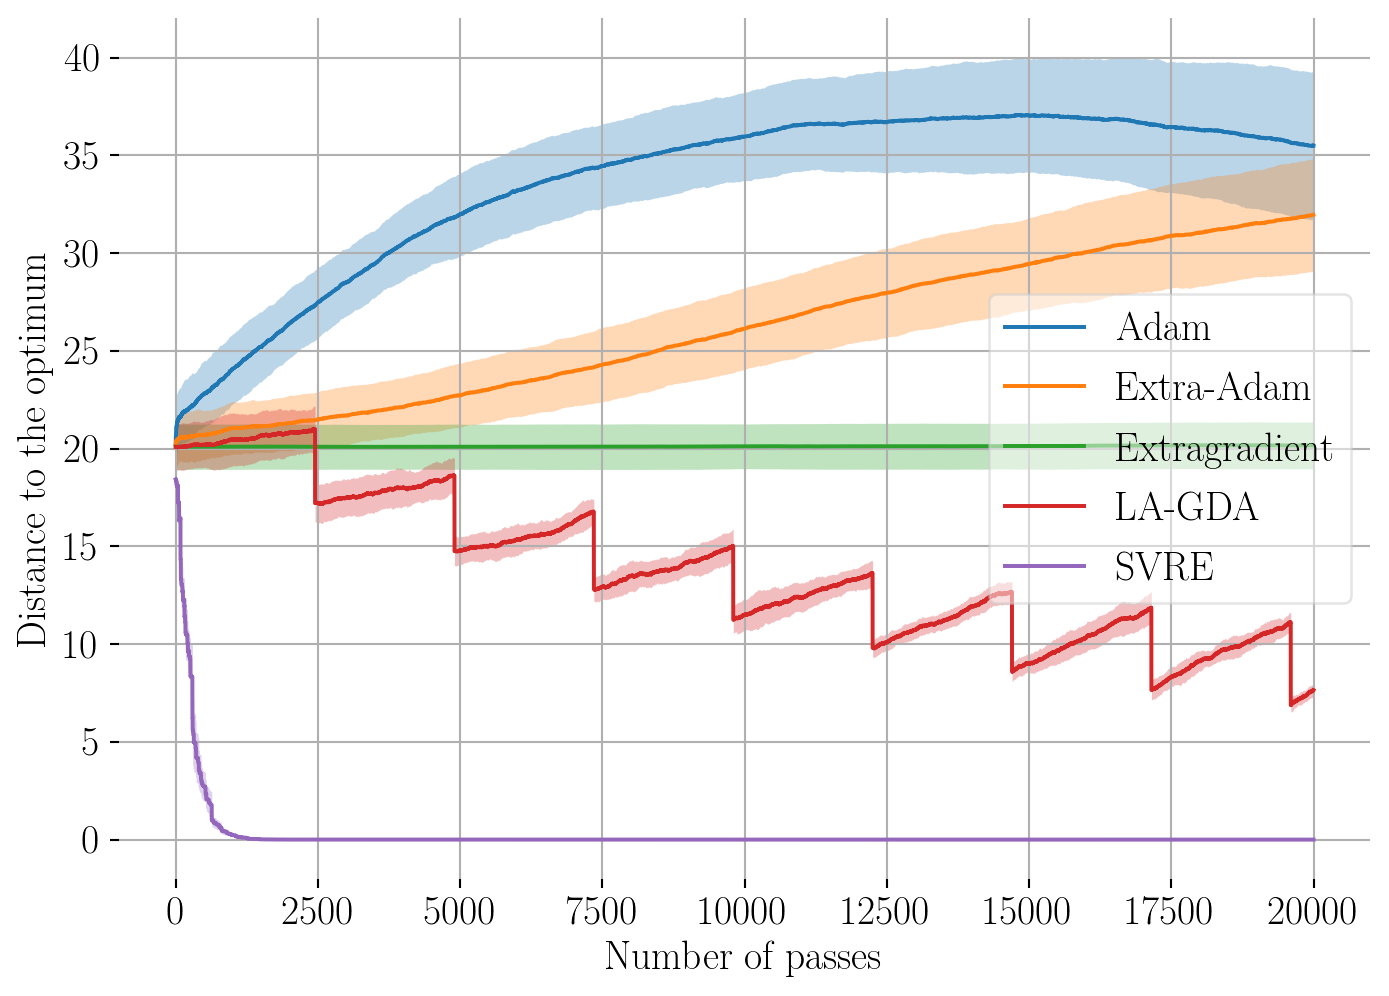

In [ ]:
import json

with open("./svre_results.json", 'r') as fs:
  SVRE_curve = json.load(fs)

_curves4 = {
    f"Adam": curves_adam[f"Adam$, B=1$"],
    f"Extra-Adam": curves_extradam[f"Extra-Adam$, B=1$"],
    f"Extragradient": curves_extra[f"Extragradient$, B=1$"],
    f"LA-GDA": curves_la[f"LA-GAN$, B=1$"],
    f"SVRE": SVRE_curve
}

plot_curves(_curves4, "stochastic_bilinear_B=1.pdf")

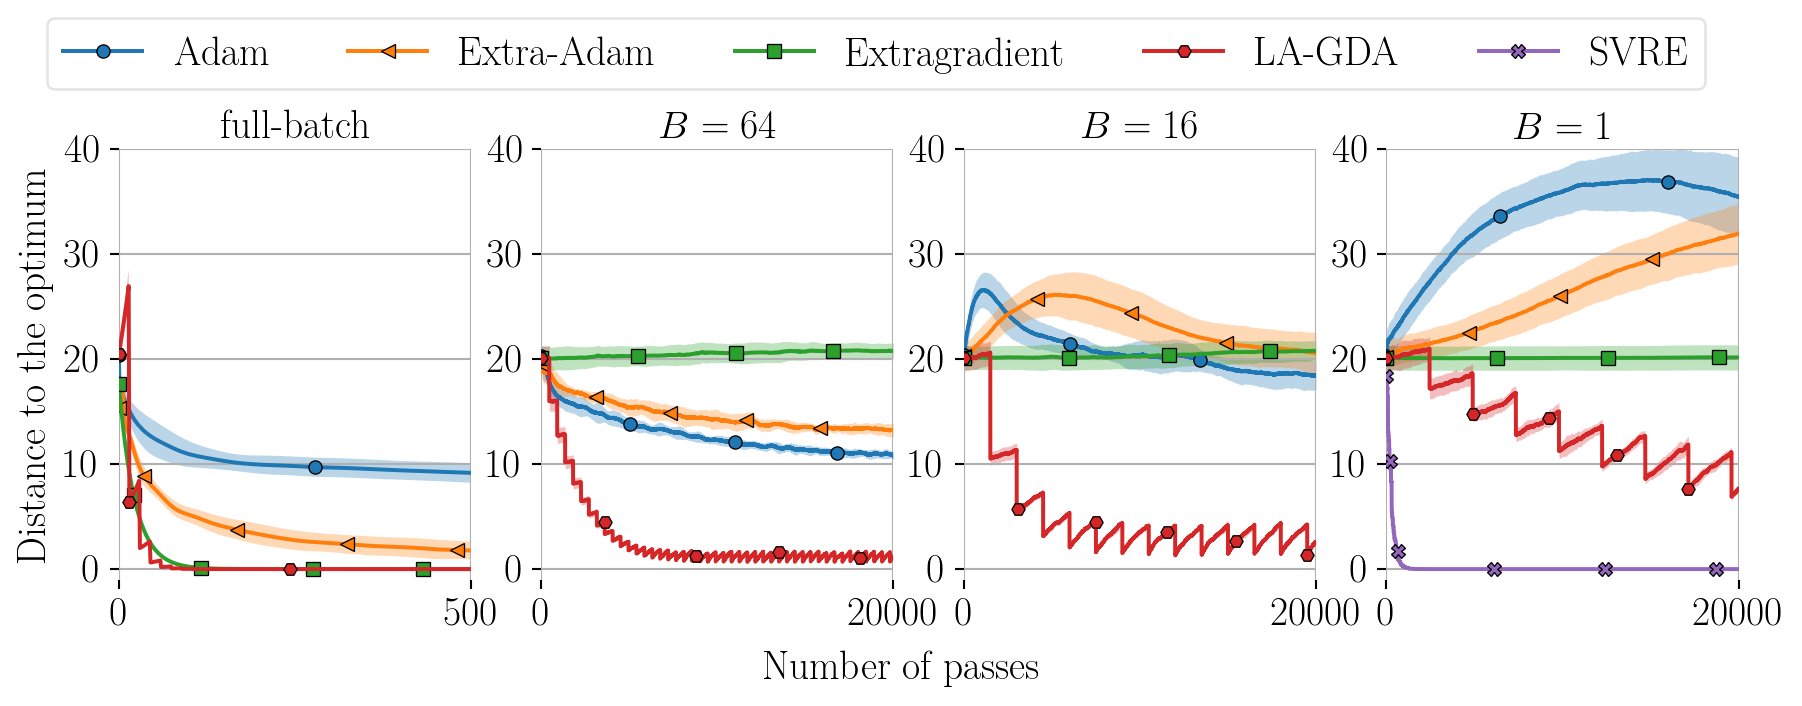

In [ ]:
def sub_plot(ax, curves, plot_std=True, markevery=0.5):
  markersize=5
  ax.spines["top"].set_visible(False)  
  ax.spines["bottom"].set_visible(False)  
  ax.spines["right"].set_visible(False)  
  ax.spines["left"].set_visible(False) 
  ax.get_xaxis().tick_bottom()  
  ax.get_yaxis().tick_left()
  plt.ylim([-1, 40])
  for i, (curve_lbl, curve) in enumerate(curves.items()):
    if i == 1 or i == 2 or i == 4:
      markevery = 0.2
    else:
      markevery = 0.5
    passes = curve['n_passes']
    curve_mean = curve['curve_mean']
    curve_std = curve['curve_std']
    plt.plot(passes, curve_mean, label=curve_lbl, color=tableau20[2*i], 
             marker=markers[3*i], markevery=markevery, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5, rasterized=True) #semilogy
    if plot_std:
      low  = [m - s for m, s in zip(curve_mean, curve_std)]
      high = [m + s for m, s in zip(curve_mean, curve_std)]
      plt.fill_between(passes, low, high, alpha=.3, color=tableau20[i*2], linewidth=0, rasterized=True)
  plt.grid()
  ax = plt.gca()
  ax.yaxis.grid(True, which='minor', linestyle='-.')

def stochastic_bilinear_plot(curves0, curves1, curves2, curves3, filename=None, plot_std=True):
  ax = plt.subplot(141)  
  sub_plot(ax, curves0, plot_std=plot_std)
  plt.ylabel('Distance to the optimum')
  plt.xlabel('full-batch')
  ax.xaxis.set_label_position('top') 
  plt.xlim([0, 500])
  plt.xticks([0,500])
  ax = plt.subplot(142)  
  sub_plot(ax, curves1, plot_std=plot_std)
  plt.xlabel('$B=64$')
  ax.xaxis.set_label_position('top') 
  plt.xlim([0, 20000])
  plt.xticks([0,20000])
  ax = plt.subplot(143) 
  sub_plot(ax, curves2, plot_std=plot_std)
  plt.xlabel('$B=16$')
  ax.xaxis.set_label_position('top') 
  plt.xlim([0, 20000])
  plt.xticks([0,20000])
  ax = plt.subplot(144) 
  sub_plot(ax, curves3, plot_std=plot_std)
  plt.xlim([0, 20000])
  plt.xticks([0,20000])
  ax.legend(loc='upper center', bbox_to_anchor=(-1.45, 1.35),
            fancybox=True, shadow=False, ncol=5, framealpha=.5)
  plt.xlabel('$B=1$')
  ax.xaxis.set_label_position('top') 
  fig = plt.gcf()
  fig.text(0.5, -0.05, 'Number of passes', ha='center')
  if filename is not None:
    plt.savefig(filename, bbox_inches='tight')
  plt.show()

rcParams['figure.figsize'] = 11, 3
stochastic_bilinear_plot(_curves0, _curves1, _curves2, _curves4, 
                         filename="stochastic_bilinear_plot.pdf")